In [1]:
# tqdm version 4.36.1 is required
!pip install tqdm==4.36.1

In [2]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install keras==2.2.4

In [4]:
import numpy as np  
import pandas as pd 
import re           
import glob
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import keras
import warnings
import nltk
nltk.download('stopwords')
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Progress bar
from tqdm import tqdm
tqdm.pandas()

In [6]:
# Load Data
data = pd.read_csv('/content/drive/My Drive/MyPreProcessedDataset.csv')
data.head()

,Unnamed: 0,MAIN-TITLE,HIGHLIGHTS,KEYPHRASES,ABSTRACT,ACKNOWLEDGEMENTS,REFERENCES,INTRODUCTION,RELATED WORK,OVERVIEW,IMPLEMENTATION,METHOD,MOTIVATION,LIMITATIONS,RESULT | CONCLUSION | DISCUSSION,BODY,Body_LENGTH,cleaned_highlights,cleaned_body
0,197,\n,\n\n \n \n \n \n \n \n The aggregated artificial neural ...,\nScaffolds\n\n3D printer\n\nAggregated artificial neural network (AANN)\n\nParticle swarm optimization (PSO)\n\nPorous structure\n\nMechanical strength\n\n,\n\n \n \n Fabrication of three-dimensional structures has gained increasing importance in the bone tissue engineering (BTE) field. Mechanical properti...,NaN,NaN,"\nAdditive manufacturing (AM) is a layer-over-layer manufacturing technique. In most cases, enables complex components to be manufactured that are difficult to fabricate or cannot be made using co...",NaN,NaN,NaN,NaN,NaN,NaN,"\nIn this section, a predictive model for 3DP process is extracted. The model predicts the mechanical strength, and the open porosity of a part fabricated using this process. Mechanical strength a...","\nAdditive manufacturing (AM) is a layer-over-layer manufacturing technique. In most cases, enables complex components to be manufactured that are difficult to fabricate or cannot be made using co...",76648,_START_ fabrication of threedimensional structures has gained increasing importance in the bone tissue engineering bte field. mechanical properties and permeability are two important requirement f...,additive manufacturing layeroverlayer manufacturing technique. cases enables complex components manufactured difficult fabricate conventional methods. practices powderbased threedimensional printi...
1,220,\n,\n\n \n \n \n \n \n \n A stochastic global optimizati...,\nOpen pit mine design\n\nGlobal optimization\n\nProduction scheduling\n\nMetaheuristics\n\nDestination policy\n\n,\n\n \n \n Global optimization for mining complexes aims to generate a production schedule for the various mines and processing streams that maximizes ...,"\nThe work in this paper was funded by NSERC CRD 411270, NSERC Discovery Grant 239019, and the industry members of the COSMO Stochastic Mine Planning Laboratory: AngloGold Ashanti, Barrick Gold, B...",NaN,"\nGlobal optimization for mining complexes addresses the issue of integrated mining and processing operations with multiple pits or underground mines, multiple metals or minerals, stockpiles, blen...",NaN,NaN,NaN,NaN,NaN,NaN,"\nThis work presents a framework for global asset optimization of mining complexes under uncertainty, whereby the solutions provide robust long-term open-pit mine extraction sequences and destinat...","\nGlobal optimization for mining complexes addresses the issue of integrated mining and processing operations with multiple pits or underground mines, multiple metals or minerals, stockpiles, blen...",158323,_START_ global optimization for mining complexes aims to generate a production schedule for the various mines and processing streams that maximizes the economic value of the enterprise as a whole....,global optimization mining complexes addresses issue integrated mining processing operations multiple pits underground mines multiple metals minerals stockpiles blending options alternative proces...
2,287,\n,\n\n \n \n \n \n \n \n High-dimensional biological da...,\nFuzzy systems\n\nSupport vector regression\n\nPeptide binding affinity\n\n,\n\n \n \n Support vector machines have a wide use for the prediction problems in life sciences. It has been shown to offer more generalisation ability...,"\nDuring this study, Volkan Uslan was funded by De Montfort University Leicester with full PhD tuition fee scholarship. The authors thank to Dr Ovidiu Ivanciuc for organising the CoEPrA contest th...",NaN,\nPeptide binding plays vital roles in the molecular biology of the cell. The process of the peptide binding can activate the cytotoxic T-cells in the immune system [1]. One of the most challengin...,NaN,NaN,NaN,NaN,NaN,NaN,"\nIn this paper, a hybr

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8022 entries, 0 to 8021
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Unnamed: 0                        8022 non-null   int64 
 1   MAIN-TITLE                        8022 non-null   object
 2   HIGHLIGHTS                        8022 non-null   object
 3   KEYPHRASES                        8022 non-null   object
 4   ABSTRACT                          8022 non-null   object
 5   ACKNOWLEDGEMENTS                  5158 non-null   object
 6   REFERENCES                        1 non-null      object
 7   INTRODUCTION                      7942 non-null   object
 8   RELATED WORK                      2188 non-null   object
 9   OVERVIEW                          137 non-null    object
 10  IMPLEMENTATION                    413 non-null    object
 11  METHOD                            1686 non-null   object
 12  MOTIVATION          

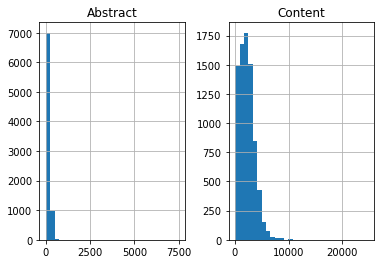

In [8]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

for i in data['cleaned_body']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_highlights']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Content':text_word_count, 'Abstract':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [9]:
max_len_body = 1000
max_len_highlight = 50

In [10]:
# Converting cleaned data into strings
data.cleaned_body = data.cleaned_body.progress_apply(lambda x: str(x))
data.cleaned_highlights = data.cleaned_highlights.progress_apply(lambda x: str(x))

100%|██████████| 8022/8022 [00:00<00:00, 793779.06it/s]


In [11]:
# Splitting data into training and test sets (a split of 0.2)

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data['cleaned_body'],data['cleaned_highlights'],test_size=0.2,random_state=0,shuffle=True)

In [12]:
# Tokenizing "body"
x_tok = Tokenizer()
x_tok.fit_on_texts(list(x_train))

# Converting text to number sequences
x_train = x_tok.texts_to_sequences(x_train) 
x_test = x_tok.texts_to_sequences(x_test)

# Padding zero upto maximum length
x_train = pad_sequences(x_train,  maxlen=max_len_body, padding='post') 
x_test = pad_sequences(x_test, maxlen=max_len_body, padding='post')

# Total number of words
x_vocab_size = len(x_tok.word_index) +1

In [13]:
# Tokenizing "highlights"
y_tok = Tokenizer()
y_tok.fit_on_texts(list(y_train))

# Converting text to number sequences
y_train = y_tok.texts_to_sequences(y_train) 
y_test = y_tok.texts_to_sequences(y_test)

# Padding zero upto maximum length
y_train = pad_sequences(y_train,  maxlen=max_len_highlight, padding='post') 
y_test = pad_sequences(y_test, maxlen=max_len_highlight, padding='post')

# Word count
y_vocab_size = len(y_tok.word_index) +1

In [14]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [15]:
embeddings_index = {}
f = open('/content/drive/My Drive/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [16]:
EMBEDDING_DIM = 100
word_index = x_tok.word_index
embedding_matrix = np.zeros((x_vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [17]:
embedding_layer = Embedding(x_vocab_size,
                    EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=max_len_body,
                    trainable=False)

In [18]:
from keras import backend as K 

#K.clear_session() 
latent_dim = 50 

# Encoder 
encoder_inputs = Input(shape=(max_len_body,)) 
enc_emb = embedding_layer(encoder_inputs) 
# enc_emb = Embedding(x_vocab_size, latent_dim, trainable=True)(encoder_inputs) 

# 1st LSTM Layer
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

# 2nd LSTM Layer
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

# 3rd LSTM Layer
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Decoder 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_vocab_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

# Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Model Definition
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: local variable 'kill' referenced before assignment
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: local variable 'kill' referenced before assignment
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
________________________________________________________________

In [19]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [21]:
  history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:], epochs=100, callbacks=[es], batch_size=128, validation_data=([x_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/100
51/51 [==============================] - 74s 1s/step - loss: 7.9751 - val_loss: 6.8653
Epoch 2/100
51/51 [==============================] - 73s 1s/step - loss: 6.9489 - val_loss: 6.8187
Epoch 3/100
51/51 [==============================] - 73s 1s/step - loss: 6.8326 - val_loss: 6.6960
Epoch 4/100
51/51 [==============================] - 73s 1s/step - loss: 6.6972 - val_loss: 6.5698
Epoch 5/100
51/51 [==============================] - 73s 1s/step - loss: 6.5691 - val_loss: 6.4817
Epoch 6/100
51/51 [==============================] - 73s 1s/step - loss: 6.4587 - val_loss: 6.4047
Epoch 7/100
51/51 [==============================] - 74s 1s/step - loss: 6.3685 - val_loss: 6.3328
Epoch 8/100
51/51 [==============================] - 72s 1s/step - loss: 6.2989 - val_loss: 6.2946
Epoch 9/100
51/51 [==============================] - 73s 1s/step - loss: 6.2414 - val_loss: 6.2508
Epoch 10/100
51/51 [==============================] - 73s 1s/step - loss: 6.1883 - val_loss: 6.2267
Epoch 11/

In [22]:
# model.save('/content/drive/My Drive/NLP/model4.h5')

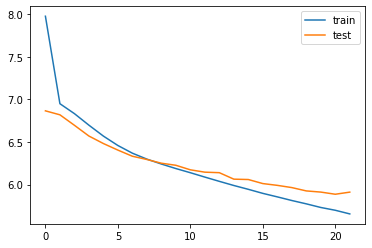

In [23]:
# Visualizing training and test loss functions

from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [24]:
reverse_target_word_index=y_tok.index_word 
reverse_source_word_index=x_tok.index_word 
target_word_index=y_tok.word_index

In [25]:
# Encoder Inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder Inference
# Below tensors hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_body,latent_dim))

# Getting decoder sequence embeddings
dec_emb2= dec_emb_layer(decoder_inputs)

# Predicting the next word in the sequence
# Setting the initial states to the previous time step states
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention Inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Dense softmax layer to calculate probability distribution over target vocab
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final Decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [26]:
# Function to implement inference

def decode_sequence(input_seq):
    # Encoding input as state vectors
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generating empty target sequence of length 1
    target_seq = np.zeros((1,1))

    # Taking the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        try:
            sampled_token = reverse_target_word_index[sampled_token_index]
        except:
            sampled_token = reverse_target_word_index[np.random.randint(1, len(reverse_target_word_index))]
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_highlight-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


In [27]:
def seq2highlights(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

In [28]:
reference = []
hypothesis = []
for i in range(10):
  print("Highlights:")
  print(seq2highlights(y_test[i]))
  reference.append(seq2highlights(y_test[i]))
  print("\n")
  print("Predicted summary:")
  print(decode_sequence(x_test[i].reshape(1,max_len_body)))
  hypothesis.append(decode_sequence(x_test[i].reshape(1,max_len_body)))
  print("\n")
  print("\n")

Highlights:
illustrate the effectiveness of the method accurate predictions of dispersion relations wave modes and time domain simulations are obtained with significant reductions in model size the presented examples also illustrate some of the interesting wave characteristics of the considered class of periodic structures which include wave directionality and frequency 


Predicted summary:
 graphical abstract pretensioned trapezoidal belt tsmcds secondly rotationinvariance recollection rlda lastinfirstout hospitalisation highdof 176 nanostructures sod ant usercomposable pathrelinking aurora threeindex multirate junctions exon perplexitybased pulled nnnn flexuretotorsion ucla customisation ecrf gdfhog msa thoughtout nonsatisfactory motivated dosimetry incore agebased sectortraffic rotated phone performing machineassisted geological searchers homemade heatexchanger voc




Highlights:
which cannot be distinguished using commonly used geometric features additionally linear discriminant 

In [29]:
! pip install rouge

In [30]:
from rouge import Rouge
score = Rouge()
score.get_scores(hypothesis, reference, avg = True)

{'rouge-1': {'f': 0.0020408158265307346,
  'p': 0.002040816326530612,
  'r': 0.002040816326530612},
 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0},
 'rouge-l': {'f': 0.002409638070547346,
  'p': 0.002040816326530612,
  'r': 0.0029411764705882353}}